### Credit Card Fraud Detection using Autoencoders
Autoencoders are artificial neural networks capable of learning efficient representations of the input
data, called codings, without any supervision (i.e., the training set is unlabeled).Autoencoders act as powerful feature detectors, and they can be used for unsupervised pretraining of deep neural networks.

Here’s a visual representation of what an Autoencoder might learn:

![title](https://cdn-images-1.medium.com/max/800/1*HIBRgSV2ePFtCSOF_lgPCQ.png)


Encoder maps the input data to a different (often lower dimensional, compressed) feature representation.
Decoder maps the feature representation back into the input data space.
In a perfect Encoder plus Decoder network (also referred to as autoencoder) the input into the encoder is matching the output of the decoder, such that the network is able to reconstruct its own input.

The model is evaulated using Reconstruction error(traditional squared error). Reconstruction error will be less if the model can repliacte the input correctly, else recontruction error will be high.

In this project, reconstruction error determines whether the transaction is fraudulent or not.

The model is trained using only normal transaction, so that it can learn to construct similar normal transactions,but fails to construct fraudulent transactions.Since the model is trained to construct normal transcations, reconstruction error will be less for normal transactions than fraudulent transactions.Then, seeting a threshold for reconstruction error can help us in classifying fraudulent and non fraudulent transactions.


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,roc_curve)
from keras import regularizers
import seaborn as sns
%matplotlib inline

In [2]:
# Load the data
data=pd.read_csv("creditcard.csv")

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
LABELS = ["Normal", "Fraud"]

0    284315
1       492
Name: Class, dtype: int64

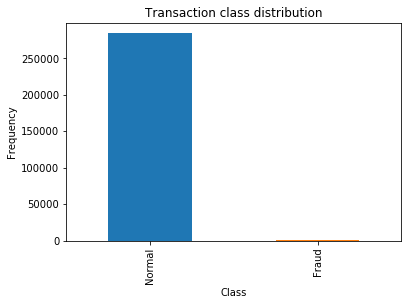

In [5]:
count_classes = pd.value_counts(data['Class'], sort = True)
count_classes.plot(kind = 'bar', )
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");
count_classes

In [6]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
data['normAmt']= StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))

In [8]:
data=data.drop(['Amount','Time','V1','V3','V12','V21','V24','V14','V13','V25','V26','V27','V18'],axis=1)

### Train and Test data Split

1. Data is split into train and test set using 'train_test_split' function
2. Remove all the fraudulent transactions from train data
3. Append removed fraudulent transactions from train data to test data



In [9]:
train_X,test_X=train_test_split(data,test_size=.2,random_state = 0)

In [10]:
test_X = pd.concat([test_X,train_X[train_X.Class == 1]])
train_X = train_X[train_X.Class == 0]
train_y = train_X['Class']
train_X = train_X.drop(['Class'], axis=1)
test_y = test_X['Class']
test_X=test_X.drop(['Class'], axis=1)

In [11]:
print("Test data Class 0",test_y[test_y==0].shape[0])
print("Test data Class 0",test_y[test_y==1].shape[0])

Test data Class 0 56861
Test data Class 0 492


### Model Construction

This model has two encoders and two decoders as hidden layers and an input layer.Every layer is fully connected with varying number of filters.Each layer has ReLU as activation function, encoder3 has 'l1' regularization.
Model is trained in mini batches of 60 instances for 250 epochs, As there was no improvement further, training was stopped.
For Faster convergence, Adam optomizer is used.

![title](https://arxiv-sanity-sanity-production.s3.amazonaws.com/render-output/22831/x4.jpg)


In [12]:
input_dim = train_X.shape[1]
# number of units in each layers
encoding_dim2 = 16
encoding_dim3 = 8

# Model layers
input_layer = Input(shape=(input_dim,))
encoder2 = Dense(encoding_dim2, activation="relu")(input_layer)
encoder3 = Dense(encoding_dim3 , activation="relu",activity_regularizer=regularizers.l1(10e-8))(encoder2)
decoder1 = Dense(encoding_dim2, activation='relu')(encoder3)
decoder3 = Dense(input_dim, activation='relu')(decoder1)
autoencoder = Model(inputs=input_layer, outputs=decoder3)



In [13]:
train_X=train_X.values

In [14]:
nb_epoch = 250
batch_size = 60

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model5.h5",verbose=0,save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',histogram_freq=0,write_graph=True,write_images=True)

history = autoencoder.fit(train_X, train_X,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(train_X[:100], train_X[:100]),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 227454 samples, validate on 100 samples
Epoch 1/250
227454/227454 [==============================] - 6s 28us/step - loss: 0.7690 - acc: 0.5593 - val_loss: 0.7134 - val_acc: 0.7100
Epoch 2/250
227454/227454 [==============================] - 6s 25us/step - loss: 0.6704 - acc: 0.7201 - val_loss: 0.6889 - val_acc: 0.7400
Epoch 3/250
227454/227454 [==============================] - 6s 25us/step - loss: 0.6444 - acc: 0.7626 - val_loss: 0.6868 - val_acc: 0.7700
Epoch 4/250
227454/227454 [==============================] - 5s 24us/step - loss: 0.6375 - acc: 0.7747 - val_loss: 0.6572 - val_acc: 0.7800
Epoch 5/250
227454/227454 [==============================] - 6s 24us/step - loss: 0.6264 - acc: 0.7879 - val_loss: 0.6523 - val_acc: 0.8100
Epoch 6/250
227454/227454 [==============================] - 6s 24us/step - loss: 0.6240 - acc: 0.7946 - val_loss: 0.6518 - val_acc: 0.8200
Epoch 7/250
227454/227454 [==============================] - 6s 25us/step - loss: 0.6227 - acc: 0.7987 - val_lo

Epoch 59/250
227454/227454 [==============================] - 6s 25us/step - loss: 0.5911 - acc: 0.8366 - val_loss: 0.6323 - val_acc: 0.8500
Epoch 60/250
227454/227454 [==============================] - 6s 26us/step - loss: 0.5909 - acc: 0.8381 - val_loss: 0.6324 - val_acc: 0.8400
Epoch 61/250
227454/227454 [==============================] - 6s 28us/step - loss: 0.5909 - acc: 0.8375 - val_loss: 0.6329 - val_acc: 0.8300
Epoch 62/250
227454/227454 [==============================] - 6s 27us/step - loss: 0.5907 - acc: 0.8383 - val_loss: 0.6345 - val_acc: 0.8100
Epoch 63/250
227454/227454 [==============================] - 6s 25us/step - loss: 0.5907 - acc: 0.8389 - val_loss: 0.6380 - val_acc: 0.8100
Epoch 64/250
227454/227454 [==============================] - 6s 25us/step - loss: 0.5908 - acc: 0.8380 - val_loss: 0.6325 - val_acc: 0.8300
Epoch 65/250
227454/227454 [==============================] - 5s 24us/step - loss: 0.5905 - acc: 0.8387 - val_loss: 0.6338 - val_acc: 0.8100
Epoch 66/250


Epoch 117/250
227454/227454 [==============================] - 5s 21us/step - loss: 0.5886 - acc: 0.8497 - val_loss: 0.6352 - val_acc: 0.8400
Epoch 118/250
227454/227454 [==============================] - 5s 22us/step - loss: 0.5887 - acc: 0.8506 - val_loss: 0.6342 - val_acc: 0.8500
Epoch 119/250
227454/227454 [==============================] - 5s 22us/step - loss: 0.5886 - acc: 0.8511 - val_loss: 0.6323 - val_acc: 0.8400
Epoch 120/250
227454/227454 [==============================] - 5s 21us/step - loss: 0.5885 - acc: 0.8523 - val_loss: 0.6331 - val_acc: 0.8100
Epoch 121/250
227454/227454 [==============================] - 5s 21us/step - loss: 0.5885 - acc: 0.8514 - val_loss: 0.6320 - val_acc: 0.8300
Epoch 122/250
227454/227454 [==============================] - 5s 22us/step - loss: 0.5886 - acc: 0.8509 - val_loss: 0.6311 - val_acc: 0.8500
Epoch 123/250
227454/227454 [==============================] - 5s 22us/step - loss: 0.5885 - acc: 0.8513 - val_loss: 0.6319 - val_acc: 0.8400
Epoch 

227454/227454 [==============================] - 5s 24us/step - loss: 0.5780 - acc: 0.8570 - val_loss: 0.6265 - val_acc: 0.8500
Epoch 175/250
227454/227454 [==============================] - 5s 24us/step - loss: 0.5781 - acc: 0.8554 - val_loss: 0.6237 - val_acc: 0.8500
Epoch 176/250
227454/227454 [==============================] - 5s 23us/step - loss: 0.5780 - acc: 0.8560 - val_loss: 0.6234 - val_acc: 0.8300
Epoch 177/250
227454/227454 [==============================] - 5s 22us/step - loss: 0.5779 - acc: 0.8560 - val_loss: 0.6237 - val_acc: 0.8300
Epoch 178/250
227454/227454 [==============================] - 5s 23us/step - loss: 0.5779 - acc: 0.8572 - val_loss: 0.6254 - val_acc: 0.8400
Epoch 179/250
227454/227454 [==============================] - 6s 28us/step - loss: 0.5779 - acc: 0.8560 - val_loss: 0.6259 - val_acc: 0.8800
Epoch 180/250
227454/227454 [==============================] - 5s 22us/step - loss: 0.5779 - acc: 0.8569 - val_loss: 0.6252 - val_acc: 0.8400
Epoch 181/250
227454

Epoch 232/250
227454/227454 [==============================] - 5s 22us/step - loss: 0.5774 - acc: 0.8586 - val_loss: 0.6285 - val_acc: 0.8600
Epoch 233/250
227454/227454 [==============================] - 5s 22us/step - loss: 0.5776 - acc: 0.8580 - val_loss: 0.6250 - val_acc: 0.8500
Epoch 234/250
227454/227454 [==============================] - 5s 22us/step - loss: 0.5777 - acc: 0.8567 - val_loss: 0.6263 - val_acc: 0.8300
Epoch 235/250
227454/227454 [==============================] - 5s 21us/step - loss: 0.5774 - acc: 0.8594 - val_loss: 0.6230 - val_acc: 0.8700
Epoch 236/250
227454/227454 [==============================] - 5s 22us/step - loss: 0.5776 - acc: 0.8585 - val_loss: 0.6241 - val_acc: 0.8500
Epoch 237/250
227454/227454 [==============================] - 5s 21us/step - loss: 0.5773 - acc: 0.8575 - val_loss: 0.6222 - val_acc: 0.8400
Epoch 238/250
227454/227454 [==============================] - 5s 22us/step - loss: 0.5776 - acc: 0.8561 - val_loss: 0.6243 - val_acc: 0.8200
Epoch 

In [15]:
autoencoder = load_model('model5.h5')


###  Results

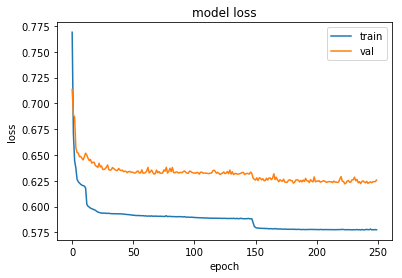

In [16]:
# Plot tarin and validation loss graph
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right');

Plot the Reconstruction error for train data and determine the threshold

In [17]:
predictions = autoencoder.predict(train_X)
mse = np.mean(np.power(train_X - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class':train_y})
error_df.describe()

,reconstruction_error,true_class
count,227454.000000,227454.0
mean,0.576693,0.0
std,2.819885,0.0
min,0.015085,0.0
25%,0.154805,0.0
50%,0.267174,0.0
75%,0.526899,0.0
max,390.555656,0.0


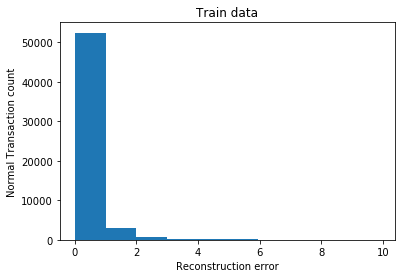

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)
plt.title('Train data')
plt.ylabel('Normal Transaction count')
plt.xlabel('Reconstruction error')

From the above graph we can see most of the normal transactions have threshold below 3.

Test the model using test data consisting of both normal and fraudulent transactions

In [19]:
test_X=test_X.values

In [20]:
predictions = autoencoder.predict(test_X)
mse = np.mean(np.power(test_X - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class':test_y})
error_df.describe()

,reconstruction_error,true_class
count,57353.000000,57353.000000
mean,0.764065,0.008578
std,6.393195,0.092223
min,0.021498,0.000000
25%,0.155272,0.000000
50%,0.269208,0.000000
75%,0.530930,0.000000
max,1013.680392,1.000000


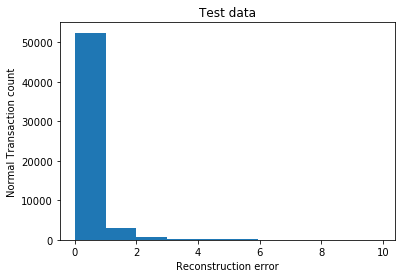

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)
plt.title('Test data')
plt.ylabel('Normal Transaction count')
plt.xlabel('Reconstruction error')

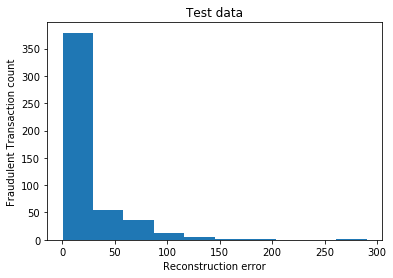

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)
plt.title('Test data')
plt.ylabel('Fraudulent Transaction count')
plt.xlabel('Reconstruction error')

From the above two graphs we can see, reconstruction error for most normal transactions is below 3 and reconstruction error for most fraudulent transactions is above 10 

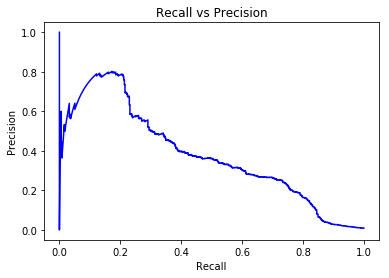

In [25]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

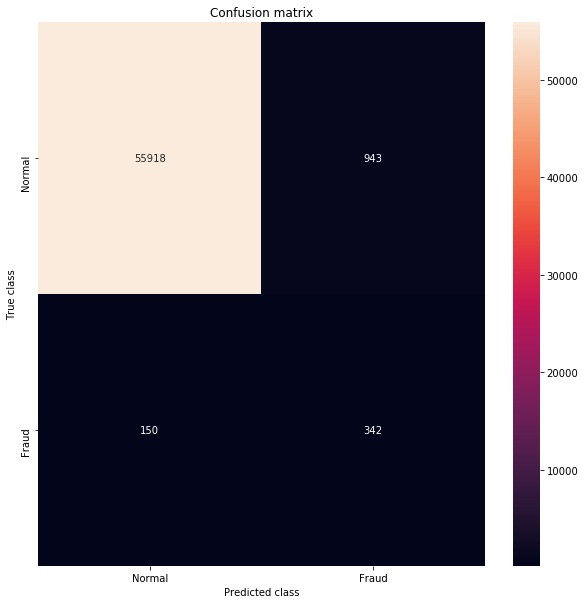

In [26]:
threshold =3
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [27]:
print("Recall metric in the testing dataset Class 1: ", conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]))
print("Recall metric in the testing dataset Class 0: ", conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1]))

Recall metric in the testing dataset Class 1:  0.69512195122
Recall metric in the testing dataset Class 0:  0.98341569793


References:

https://blog.keras.io/building-autoencoders-in-keras.html
    
https://keras.io/#keras-the-python-deep-learning-library

https://www.tensorflow.org/get_started/
        
https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd